In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

import scoring as score # para hacer los reportes de puntajes
from time import time

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.preprocessing import RobustScaler  
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

properati = pd.read_csv('datos/properati_final.csv',error_bad_lines=False)

<IPython.core.display.Javascript object>

In [3]:
properati.info()
properati=properati.loc[properati.price_aprox_usd<1e6]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136356 entries, 0 to 136355
Data columns (total 23 columns):
created_on                    136356 non-null object
property_type                 136356 non-null object
place_name                    136356 non-null object
state_name                    136356 non-null object
lat-lon                       136356 non-null object
lat                           96345 non-null float64
lon                           96345 non-null float64
price                         136356 non-null float64
currency                      136356 non-null object
price_aprox_local_currency    136356 non-null float64
price_aprox_usd               136356 non-null float64
surface_total_in_m2           136356 non-null float64
surface_covered_in_m2         136356 non-null float64
price_usd_per_m2              136356 non-null float64
price_per_m2                  136356 non-null float64
floor                         14295 non-null float64
rooms                         6963

In [4]:
properati.loc[:,('created_on')] = pd.to_datetime(properati['created_on'])
properati['anio'] = [x.year for x in properati['created_on'] ]

In [5]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

# RF clasificador

In [6]:
cant_buckets = 200

#buckets
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
properati['price_range']=pd.cut(properati['price_usd_per_m2'],rango)
#lo casteo a float porque si no tira error 
properati['categories_by_price']=properati['categories_by_price'].astype(np.float64) 
properati.groupby('categories_by_price').count().sort_values("lat",ascending=True)

,created_on,property_type,place_name,state_name,lat-lon,lat,lon,price,currency,price_aprox_local_currency,...,floor,rooms,expenses,properati_url,description,title,fecha,superficie_descubierta,anio,price_range
categories_by_price,,,,,,,,,,,,,,,,,,,,,
177.0,17,17,17,17,17,12,12,17,17,17,...,3,11,0,17,17,17,17,13,17,17
193.0,16,16,16,16,16,14,14,16,16,16,...,0,8,1,16,16,16,16,9,16,16
175.0,19,19,19,19,19,14,14,19,19,19,...,1,16,5,19,19,19,19,14,19,19
190.0,22,22,22,22,22,15,15,22,22,22,...,0,17,5,22,22,22,22,16,22,22
198.0,19,19,19,19,19,16,16,19,19,19,...,1,12,3,19,19,19,19,11,19,19
195.0,21,21,21,21,21,19,19,21,21,21,...,1,15,2,21,21,21,21,11,21,21
191.0,29,29,29,29,29,20,20,29,29,29,...,4,19,5,29,29,29,29,15,29,29
189.0,26,26,26,26,26,21,21,26,26,26,...,1,20,8,26,26,26,26,18,26,26
173.0,29,29,29,29,29,22,22,29,29,29,...,1,18,2,29,29,29,29,24,29,29


In [7]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
    properati['surface_covered_in_m2'],properati['property_type'],properati['state_name'],properati['place_name'])
y = properati['categories_by_price']

### Busco hiper-parametros con random search

In [8]:
%%notify

rf = RandomForestClassifier(n_jobs=-1)

oob_score=[True,False]
criterion = ['gini','entropy']
max_features =["auto","log2",None]
n_estimators = np.arange(10,20,5)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators,"oob_score":oob_score}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

ValueError: The total space of parameters 24 is smaller than n_iter=50. For exhaustive searches, use GridSearchCV.

<IPython.core.display.Javascript object>

ValueError: The total space of parameters 24 is smaller than n_iter=50. For exhaustive searches, use GridSearchCV.

In [ ]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

In [ ]:
search.score(X_test,y_test) # pruebo el estimador refiteado con el set de test

# RF Regresor

In [23]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['property_type'],properati['state_name'],properati['place_name'])
y = properati['price_aprox_usd']

In [ ]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =["auto","log2",None]
n_estimators = np.arange(10,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = RandomizedSearchCV(rf, param_distributions=param_grid ,cv=5,n_iter=50) #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

### Hago GS en los mejores

In [25]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
#n_estimators = np.arange(50,90,5)
n_estimators = [80]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=20,scoring="neg_mean_squared_error") #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X_train, y_train)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 82.42 segundos para 1 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -1304028659.944 (std: 5787687.796)
Promedio validation score: -5341049484.188 (std: 304644121.523)
Promedio fit time: 2.718s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 80, 'criterion': 'mse'}



<IPython.core.display.Javascript object>

In [26]:
mejor_rf = search.best_estimator_
print mejor_rf.feature_importances_ # la importancia de cada feature (cuanta informacion le provee al rf) ordenado tal y cual esta zipeado el X

[ 0.27899384  0.45811432  0.08591291  0.05616266  0.12081628]


In [27]:
search.score(X_test,y_test)

-5190431835.9389553

In [28]:
errores = mejor_rf.predict(X_test)-y_test
print ("Error maximo:{0}\nError minimo:{1}".format( max(abs(errores)),min(abs(errores))))
print(errores)

Error maximo:790854.166667
Error minimo:0.0
86615      34947.518939
22480     -77921.021429
111734     20970.925000
49425     -15127.162500
106828    -91405.104167
8945       53120.183333
41066     -44990.833333
85270      15954.630833
60524     -68928.346875
21948      25514.391234
126295    -13610.006101
75477      -2891.557224
87023      35923.011364
22177       -981.776515
110487    -20425.000000
20262     -39093.750000
24972     178900.000000
85475      38824.411491
23084      62303.699645
135677     -5227.072024
95054        -77.892740
57825      16165.026450
103810     19911.062500
31679      15400.584809
102198     16814.906473
113638       968.109722
21818      56575.000000
74763     -18192.500000
97903      14990.493750
15455      64257.592234
              ...      
1756       11486.126298
39806       4953.249008
46955     -15950.000000
52473       1564.583333
114881    -28125.283301
55088     -11200.000000
50492       -421.537363
46296      -8710.110629
8994      -23416.666

## Analsis de errores

In [29]:
count_max=0
max_error=5
lista=[]
for error in errores:
    if abs(error)>=max_error:
        count_max+=1
        lista.append(abs(error))
print ("Hay {0} de {1} que tienen mas de {2} USD de error ({3}%)".format(count_max,len(errores),max_error,100 * count_max/len(errores)))

Hay 26522 de 26640 que tienen mas de 5 USD de error (99%)


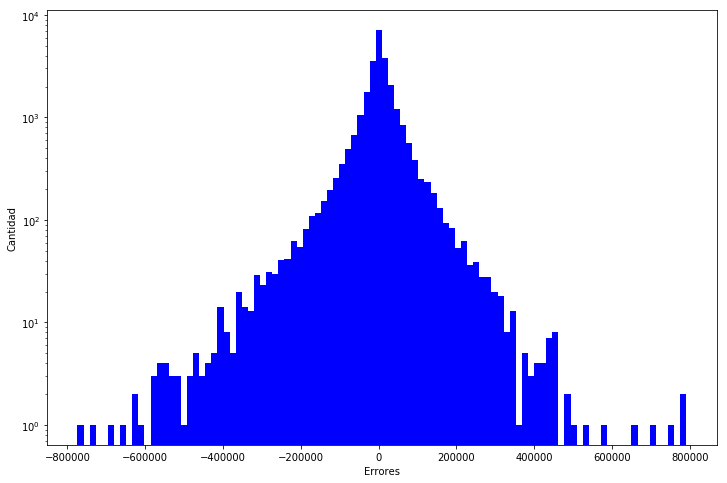

In [30]:
# the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

###  Distribucion de precios

In [ ]:
plt.figure(figsize=(12,8))
cant_buckets=1000
cantidad,rango = np.histogram(properati['price_usd_per_m2'], bins=cant_buckets)
properati['categories_by_price']=pd.cut(properati['price_usd_per_m2'],rango,labels=np.arange(cant_buckets),include_lowest=True)
plt.hist(properati.categories_by_price,cant_buckets,facecolor='green')
plt.show()

## Pruebo reduccion con RF

In [ ]:
X = zip(properati['dist_a_subte'],properati['dist_a_univ'],properati['dist_a_tren'],properati['dist_a_villa'],\
        properati['dist_a_zona_anegada'],properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['lat'],properati['lon'])

y = properati['price_aprox_usd']

X=scaler.fit_transform(X,y)

In [ ]:
%%notify

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

estimators = [('pca', PCA()), ('rf', RandomForestRegressor())]
pipe = Pipeline(estimators)

criterion = ['mse']
max_features =['log2']
n_estimators = np.arange(170,200,10)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)

param_grid= dict( pca__n_components=np.arange(1,8,1),rf__criterion = criterion,
rf__max_features =max_features,
rf__n_estimators = n_estimators)

grid_search = GridSearchCV(pipe, param_grid=param_grid,n_jobs=-1,refit=True,cv=5)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_estimator_.score(X_test,y_test)

In [ ]:
estimador_pipe=grid_search.best_estimator_
estimador_pipe

In [ ]:
estimador_pipe.get_params
estimador_pipe.steps[1][1].feature_importances_

In [ ]:
errores = estimador_pipe.predict(X_test)-y_test

In [ ]:
 # the histogram of the data
plt.figure(figsize=(12,8))
plt.hist(errores, 100, facecolor='blue')
plt.xlabel('Errores')
plt.ylabel('Cantidad')
#plt.xlim(-1000, 1000) #para variar el "zoom a 0"
plt.yscale('log')
plt.show()

# Probando set Kaggle

In [2]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=properati['state_name']
le_barrio.fit(barrios)
properati['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=properati['place_name']
le_zona.fit(zona)
properati['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=properati['property_type']
le_tipo.fit(tipos_prop)
properati['property_type'] = le_tipo.transform(tipos_prop)

In [3]:
#preparo set de datos
X = zip(properati['surface_total_in_m2'],\
        properati['surface_covered_in_m2'],properati['property_type'],properati['state_name'],properati['place_name'])
y = properati['surface_total_in_m2']

In [6]:
%%notify

rf = RandomForestRegressor(n_jobs=-1)

criterion = ['mse']
max_features =['log2']
n_estimators = [80]

param_grid = {"criterion": criterion,"max_features":max_features,"n_estimators":n_estimators}

search = GridSearchCV(rf, param_grid=param_grid ,cv=20,scoring="neg_mean_squared_error") #refit deja el estimador fiteado con los mejores hiperparametros
start = time()
search.fit(X, y)

print("GridSearchCV duro %.2f segundos para %d candidatos a hiper-parametros."
    % (time() - start, len(search.cv_results_['params'])))
print("")
score.report_single(search.cv_results_)

GridSearchCV duro 96.35 segundos para 1 candidatos a hiper-parametros.

Puesto: 1
Promedio training score: -4138.260 (std: 884.852)
Promedio validation score: -27064.770 (std: 22637.812)
Promedio fit time: 3.522s
Hiper-parametros: {'max_features': 'log2', 'n_estimators': 80, 'criterion': 'mse'}



<IPython.core.display.Javascript object>

In [ ]:
test = pd.read_csv('datos/properati_dataset_testing_noprice.csv')

In [ ]:
 def recalcular_superficie(row):
    if ( np.isnan(row.surface_total_in_m2) and (row.surface_covered_in_m2 !=0) ): #si no tiene la sup total usa la descubierta como total 
        row.surface_total_in_m2 = row.surface_covered_in_m2
    if ( np.isnan(row.surface_covered_in_m2) and (row.surface_total_in_m2 !=0)): #si no tiene la sup total usa la descubierta como total 
        row.surface_covered_in_m2 = row.surface_total_in_m2
    return row
test = test.apply(recalcular_superficie,axis=1)

In [ ]:
test.info()

In [ ]:
estimador_final = search.best_estimator_

In [ ]:
#paso features con strings a numericos
le_barrio = preprocessing.LabelEncoder()
barrios=test['state_name']
le_barrio.fit(barrios)
test['state_name'] = le_barrio.transform(barrios)

le_zona = preprocessing.LabelEncoder()
zona=test['place_name']
le_zona.fit(zona)
test['place_name'] = le_zona.transform(zona)

le_tipo = preprocessing.LabelEncoder()
tipos_prop=test['property_type']
le_tipo.fit(tipos_prop)
test['property_type'] = le_tipo.transform(tipos_prop)
print le_tipo.get_params()

In [ ]:
Z = zip(test['surface_total_in_m2'],\
        test['surface_covered_in_m2'],test['property_type'],test['state_name'],test['place_name'])

In [ ]:
estimador_final.predict(Z)

In [9]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2)